In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [6]:
DATA_PATH = './CelebA/img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image
MERGE_Y = 8

In [7]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [8]:
def conv_out_size_same(size, stride): 
    return int(math.ceil(float(size) / float(stride))) 

# Initialization of batch norms
g_bn0 = batch_norm(name='g_bn0')
g_bn1 = batch_norm(name='g_bn1')
g_bn2 = batch_norm(name='g_bn2')
g_bn3 = batch_norm(name='g_bn3')

def generator(z, is_training=True):
            
    # the size of the output images
    output_height = 64
    # the size of the output images to produce. If None, same value as output_height
    output_width = 64
    # dimension of gen filters in first conv layer
    gf_dim = 64
    # dimension of number of image channels
    c_dim = 3
    # the size of batch images
    batch_size = 64
    
    s_h, s_w = output_height, output_width
    s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
    s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
    s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
    s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)
    
    with tf.variable_scope('g', reuse=False if is_training==True else True):
        # let's reshape input vector into 3d tensor. 
        z_, h0_w, h0_b = linear(z, gf_dim*8*s_h16*s_w16, 'g_h0_lin', with_w=True)
        h0 = tf.reshape(z_, [-1, s_h16, s_w16, gf_dim * 8])
        h0 = tf.nn.relu(g_bn0(h0, is_training))
        h1, h1_w, h1_b = deconv2d(h0, [batch_size, s_h8, s_w8, gf_dim*4], name='g_h1', with_w=True)
        h1 = tf.nn.relu(g_bn1(h1, is_training))
        h2, h2_w, h2_b = deconv2d(h1, [batch_size, s_h4, s_w4, gf_dim*2], name='g_h2', with_w=True)
        h2 = tf.nn.relu(g_bn2(h2, is_training))
        h3, h3_w, h3_b = deconv2d(h2, [batch_size, s_h2, s_w2, gf_dim*1], name='g_h3', with_w=True)
        h3 = tf.nn.relu(g_bn3(h3, is_training))
        # de-conv 4 with tanh
        h_out, h4_w, h4_b = deconv2d(h3, [batch_size, s_h, s_w, c_dim], name='g_out', with_w=True)

        return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [9]:
# Initialization of batch norms
d_bn1 = batch_norm(name='d_bn1')
d_bn2 = batch_norm(name='d_bn2')
d_bn3 = batch_norm(name='d_bn3')

def discriminator(image, reuse=False):
    df_dim = 64         # Dimension of discrim filters in first conv layer. [64]
    
    with tf.variable_scope('d', reuse=reuse):
        h0 = lrelu(conv2d(image, df_dim, name='d_h0_conv'))
        h1 = lrelu(d_bn1(conv2d(h0, df_dim*2, name='d_h1_conv'), train=True))
        h2 = lrelu(d_bn2(conv2d(h1, df_dim*4, name='d_h2_conv'), train=True))
        h3 = lrelu(d_bn3(conv2d(h2, df_dim*8, name='d_h3_conv'), train=True))
        h4 = linear(tf.reshape(h3, [-1, 8192]), 1, 'd_h3_lin')
    
        return tf.nn.sigmoid(h4), h4

Now let's define generator and discriminator.

In [10]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
G = generator(z)

images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])    
D_real, D_real_logits = discriminator(images)
D_fake, D_fake_logits = discriminator(G, reuse=True)

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [7]:
d_loss_real = tf.reduce_mean(tf.log(D_real))
d_loss_fake = tf.reduce_mean(tf.log(1 - D_fake))
d_loss = (-1) * (d_loss_real + d_loss_fake)
g_loss = (-1) * tf.reduce_mean(tf.log(D_fake))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [8]:
tvars = tf.trainable_variables()
d_vars = [v for v in tvars if 'd_' in v.name]

g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002
BETA = 0.5

d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data:

In [9]:
data = glob(os.path.join(DATA_PATH, "*.png"))
assert(len(data) > 0), "Length of training data should be more than zero"

Functions for training and evaluations.

In [10]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [11]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=5, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_Y],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

In [12]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint\dcgan.model
Loaded checkpoints
Epoch: [ 0] [   0/3165] time: 1.8171, d_loss: -2.13219762, g_loss: 0.23044978
Epoch: [ 0] [   1/3165] time: 2.1879, d_loss: -2.35913301, g_loss: 0.13726805
Epoch: [ 0] [   2/3165] time: 2.5534, d_loss: -2.67269897, g_loss: 0.13828947
Epoch: [ 0] [   3/3165] time: 2.9373, d_loss: -2.58073616, g_loss: 0.13304040
Epoch: [ 0] [   4/3165] time: 3.3124, d_loss: -2.14319801, g_loss: 0.18354294
Epoch: [ 0] [   5/3165] time: 3.6889, d_loss: -2.26163673, g_loss: 0.17539249
Epoch: [ 0] [   6/3165] time: 4.0672, d_loss: -2.27096033, g_loss: 0.14945079
Epoch: [ 0] [   7/3165] time: 4.4449, d_loss: -2.11188149, g_loss: 0.21245964
Epoch: [ 0] [   8/3165] time: 4.8178, d_loss: -2.67056274, g_loss: 0.10788305
Epoch: [ 0] [   9/3165] time: 5.1990, d_loss: -2.49451256, g_loss: 0.13462380
Epoch: [ 0] [  10/3165] time: 5.5778, d_loss: -2.88995600, g_loss: 0.09405006
Epoch: [ 0] [  11/3165] time: 5.961

Epoch: [ 0] [ 103/3165] time: 40.7171, d_loss: -1.88307977, g_loss: 0.25311437
Epoch: [ 0] [ 104/3165] time: 41.0782, d_loss: -3.02931023, g_loss: 0.07947752
Epoch: [ 0] [ 105/3165] time: 41.4365, d_loss: -2.61544132, g_loss: 0.13856852
Epoch: [ 0] [ 106/3165] time: 41.8284, d_loss: -2.54736996, g_loss: 0.13317259
Epoch: [ 0] [ 107/3165] time: 42.1898, d_loss: -2.54263926, g_loss: 0.11338373
Epoch: [ 0] [ 108/3165] time: 42.5370, d_loss: -3.24176216, g_loss: 0.06477945
Epoch: [ 0] [ 109/3165] time: 42.9090, d_loss: -2.86039758, g_loss: 0.10720363
Epoch: [ 0] [ 110/3165] time: 43.2996, d_loss: -3.64336181, g_loss: 0.03920622
Epoch: [ 0] [ 111/3165] time: 43.6743, d_loss: -1.76638985, g_loss: 0.35955095
Epoch: [ 0] [ 112/3165] time: 44.0448, d_loss: -2.82112050, g_loss: 0.11013908
Epoch: [ 0] [ 113/3165] time: 44.4244, d_loss: -2.98030496, g_loss: 0.09028523
Epoch: [ 0] [ 114/3165] time: 44.7814, d_loss: -1.79415929, g_loss: 0.35180530
Epoch: [ 0] [ 115/3165] time: 45.1291, d_loss: -1.81

Epoch: [ 0] [ 207/3165] time: 78.6808, d_loss: -2.51203966, g_loss: 0.16331699
Epoch: [ 0] [ 208/3165] time: 79.0265, d_loss: -2.58053279, g_loss: 0.12173242
Epoch: [ 0] [ 209/3165] time: 79.3827, d_loss: -2.32708144, g_loss: 0.15334432
Epoch: [ 0] [ 210/3165] time: 79.7304, d_loss: -2.61340427, g_loss: 0.12318558
Epoch: [ 0] [ 211/3165] time: 80.0830, d_loss: -2.10845399, g_loss: 0.22501171
Epoch: [ 0] [ 212/3165] time: 80.4411, d_loss: -2.37306499, g_loss: 0.15051854
Epoch: [ 0] [ 213/3165] time: 80.8007, d_loss: -3.14059830, g_loss: 0.06778920
Epoch: [ 0] [ 214/3165] time: 81.1419, d_loss: -1.71484959, g_loss: 0.28151774
Epoch: [ 0] [ 215/3165] time: 81.4948, d_loss: -2.11478543, g_loss: 0.20753312
Epoch: [ 0] [ 216/3165] time: 81.8668, d_loss: -2.84281516, g_loss: 0.08772811
Epoch: [ 0] [ 217/3165] time: 82.2182, d_loss: -2.80226398, g_loss: 0.08637710
Epoch: [ 0] [ 218/3165] time: 82.5587, d_loss: -2.34349537, g_loss: 0.16070379
Epoch: [ 0] [ 219/3165] time: 82.9094, d_loss: -2.50

Epoch: [ 0] [ 310/3165] time: 116.2238, d_loss: -2.99837637, g_loss: 0.07567066
Epoch: [ 0] [ 311/3165] time: 116.5993, d_loss: -3.15375400, g_loss: 0.06955460
Epoch: [ 0] [ 312/3165] time: 116.9812, d_loss: -2.74306321, g_loss: 0.10953715
Epoch: [ 0] [ 313/3165] time: 117.3770, d_loss: -2.36431646, g_loss: 0.16777351
Epoch: [ 0] [ 314/3165] time: 117.7500, d_loss: -3.53300691, g_loss: 0.05712853
Epoch: [ 0] [ 315/3165] time: 118.1201, d_loss: -1.62378573, g_loss: 0.37524754
Epoch: [ 0] [ 316/3165] time: 118.4826, d_loss: -2.90187764, g_loss: 0.11617623
Epoch: [ 0] [ 317/3165] time: 118.8536, d_loss: -2.88004947, g_loss: 0.07419732
Epoch: [ 0] [ 318/3165] time: 119.2088, d_loss: -1.61146557, g_loss: 0.36631584
Epoch: [ 0] [ 319/3165] time: 119.5639, d_loss: -2.01591921, g_loss: 0.27304554
Epoch: [ 0] [ 320/3165] time: 120.0242, d_loss: -2.72266364, g_loss: 0.11105615
Epoch: [ 0] [ 321/3165] time: 120.4944, d_loss: -2.80448699, g_loss: 0.10979986
Epoch: [ 0] [ 322/3165] time: 120.9348, 

Epoch: [ 0] [ 413/3165] time: 155.0887, d_loss: -1.70908821, g_loss: 0.46574330
Epoch: [ 0] [ 414/3165] time: 155.4419, d_loss: -3.44130588, g_loss: 0.05799451
Epoch: [ 0] [ 415/3165] time: 155.8025, d_loss: -1.33271205, g_loss: 2.90580559
Epoch: [ 0] [ 416/3165] time: 156.1597, d_loss: -3.68811870, g_loss: 0.05405639
Epoch: [ 0] [ 417/3165] time: 156.5035, d_loss: -2.13172674, g_loss: 4.92296505
Epoch: [ 0] [ 418/3165] time: 156.8577, d_loss: -1.76599693, g_loss: 0.34041306
Epoch: [ 0] [ 419/3165] time: 157.2182, d_loss: -0.97644031, g_loss: 1.59043455
Epoch: [ 0] [ 420/3165] time: 157.5884, d_loss: -2.09032607, g_loss: 0.20248669
Epoch: [ 0] [ 421/3165] time: 157.9395, d_loss: -1.39912164, g_loss: 2.29560947
Epoch: [ 0] [ 422/3165] time: 158.2852, d_loss: -2.61758184, g_loss: 0.14800027
Epoch: [ 0] [ 423/3165] time: 158.6414, d_loss: -0.79962718, g_loss: 1.71856248
Epoch: [ 0] [ 424/3165] time: 158.9935, d_loss: -2.68269157, g_loss: 0.16319826
Epoch: [ 0] [ 425/3165] time: 159.3387, 

Epoch: [ 0] [ 516/3165] time: 192.5103, d_loss: -0.98435295, g_loss: 0.94737422
Epoch: [ 0] [ 517/3165] time: 192.8664, d_loss: -1.41984522, g_loss: 0.46110255
Epoch: [ 0] [ 518/3165] time: 193.2408, d_loss: -2.95089006, g_loss: 0.08612631
Epoch: [ 0] [ 519/3165] time: 193.5945, d_loss: -1.58130312, g_loss: 0.35785252
Epoch: [ 0] [ 520/3165] time: 193.9481, d_loss: -2.25117636, g_loss: 0.17524084
Epoch: [ 0] [ 521/3165] time: 194.3008, d_loss: -2.29398370, g_loss: 0.18235533
Epoch: [ 0] [ 522/3165] time: 194.6594, d_loss: -1.84090877, g_loss: 0.35034931
Epoch: [ 0] [ 523/3165] time: 195.0155, d_loss: -2.92180037, g_loss: 0.09712558
Epoch: [ 0] [ 524/3165] time: 195.3771, d_loss: -2.39321494, g_loss: 0.14793171
Epoch: [ 0] [ 525/3165] time: 195.7213, d_loss: -2.25299621, g_loss: 0.19397254
Epoch: [ 0] [ 526/3165] time: 196.0927, d_loss: -2.74557447, g_loss: 0.09710106
Epoch: [ 0] [ 527/3165] time: 196.4324, d_loss: -2.26600623, g_loss: 0.19176424
Epoch: [ 0] [ 528/3165] time: 196.8067, 

Epoch: [ 0] [ 619/3165] time: 230.3104, d_loss: -2.50338626, g_loss: 0.18266639
Epoch: [ 0] [ 620/3165] time: 230.6756, d_loss: -2.85869360, g_loss: 0.08127488
Epoch: [ 0] [ 621/3165] time: 231.0292, d_loss: -2.52025986, g_loss: 0.13672394
Epoch: [ 0] [ 622/3165] time: 231.3828, d_loss: -2.22255683, g_loss: 0.18658239
Epoch: [ 0] [ 623/3165] time: 231.7276, d_loss: -2.35975313, g_loss: 0.14481734
Epoch: [ 0] [ 624/3165] time: 232.0777, d_loss: -2.76227045, g_loss: 0.16674650
Epoch: [ 0] [ 625/3165] time: 232.4305, d_loss: -3.28002834, g_loss: 0.07286951
Epoch: [ 0] [ 626/3165] time: 232.7807, d_loss: -2.87496257, g_loss: 0.09650891
Epoch: [ 0] [ 627/3165] time: 233.1234, d_loss: -2.86828995, g_loss: 0.10143688
Epoch: [ 0] [ 628/3165] time: 233.4747, d_loss: -2.95173526, g_loss: 0.11899772
Epoch: [ 0] [ 629/3165] time: 233.8244, d_loss: -3.57866120, g_loss: 0.04491621
Epoch: [ 0] [ 630/3165] time: 234.1636, d_loss: -2.29455876, g_loss: 0.16498502
Epoch: [ 0] [ 631/3165] time: 234.5227, 

Epoch: [ 0] [ 722/3165] time: 268.0538, d_loss: -2.38922095, g_loss: 0.16906741
Epoch: [ 0] [ 723/3165] time: 268.4045, d_loss: -1.75320673, g_loss: 0.28527850
Epoch: [ 0] [ 724/3165] time: 268.7615, d_loss: -1.16409528, g_loss: 0.63869369
Epoch: [ 0] [ 725/3165] time: 269.0988, d_loss: -1.43003583, g_loss: 0.46421748
Epoch: [ 0] [ 726/3165] time: 269.4461, d_loss: -3.10847974, g_loss: 0.07801570
Epoch: [ 0] [ 727/3165] time: 269.8131, d_loss: -1.94559240, g_loss: 0.26632172
Epoch: [ 0] [ 728/3165] time: 270.1668, d_loss: -1.80625510, g_loss: 0.29607919
Epoch: [ 0] [ 729/3165] time: 270.5318, d_loss: -3.03123355, g_loss: 0.08150472
Epoch: [ 0] [ 730/3165] time: 270.8899, d_loss: -2.54131484, g_loss: 0.13672191
Epoch: [ 0] [ 731/3165] time: 271.2495, d_loss: -2.31307936, g_loss: 0.19522128
Epoch: [ 0] [ 732/3165] time: 271.5947, d_loss: -3.06529117, g_loss: 0.09160190
Epoch: [ 0] [ 733/3165] time: 271.9439, d_loss: -2.42247081, g_loss: 0.14035025
Epoch: [ 0] [ 734/3165] time: 272.2906, 

Epoch: [ 0] [ 825/3165] time: 305.7406, d_loss: -3.13783121, g_loss: 0.09112383
Epoch: [ 0] [ 826/3165] time: 306.0890, d_loss: -2.74674439, g_loss: 0.09888079
Epoch: [ 0] [ 827/3165] time: 306.4401, d_loss: -3.00624108, g_loss: 0.08758193
Epoch: [ 0] [ 828/3165] time: 306.7889, d_loss: -2.94429064, g_loss: 0.09150536
Epoch: [ 0] [ 829/3165] time: 307.1420, d_loss: -2.88293481, g_loss: 0.08535115
Epoch: [ 0] [ 830/3165] time: 307.4976, d_loss: -1.88188040, g_loss: 0.31491521
Epoch: [ 0] [ 831/3165] time: 307.8499, d_loss: -3.20400429, g_loss: 0.08318976
Epoch: [ 0] [ 832/3165] time: 308.1986, d_loss: -2.61726546, g_loss: 0.11396132
Epoch: [ 0] [ 833/3165] time: 308.5532, d_loss: -2.35381866, g_loss: 0.19849235
Epoch: [ 0] [ 834/3165] time: 308.8994, d_loss: -3.31869578, g_loss: 0.06297319
Epoch: [ 0] [ 835/3165] time: 309.2453, d_loss: -1.01736641, g_loss: 1.24809074
Epoch: [ 0] [ 836/3165] time: 309.5964, d_loss: -2.51839948, g_loss: 0.13716903
Epoch: [ 0] [ 837/3165] time: 309.9465, 

Epoch: [ 0] [ 928/3165] time: 343.0871, d_loss: -2.48759246, g_loss: 0.15997683
Epoch: [ 0] [ 929/3165] time: 343.4373, d_loss: -1.40572894, g_loss: 3.17620993
Epoch: [ 0] [ 930/3165] time: 343.7930, d_loss: -3.25798464, g_loss: 0.06788039
Epoch: [ 0] [ 931/3165] time: 344.1476, d_loss: -2.33706903, g_loss: 3.34682965
Epoch: [ 0] [ 932/3165] time: 344.4882, d_loss: -1.48747730, g_loss: 0.36179098
Epoch: [ 0] [ 933/3165] time: 344.8309, d_loss: -1.20138466, g_loss: 0.92393416
Epoch: [ 0] [ 934/3165] time: 345.1930, d_loss: -1.53164601, g_loss: 1.77783740
Epoch: [ 0] [ 935/3165] time: 345.5422, d_loss: -1.72214758, g_loss: 0.80214322
Epoch: [ 0] [ 936/3165] time: 345.8894, d_loss: -0.85574514, g_loss: 0.84718323
Epoch: [ 0] [ 937/3165] time: 346.2421, d_loss: -1.17914486, g_loss: 0.64521742
Epoch: [ 0] [ 938/3165] time: 346.5893, d_loss: -1.08392847, g_loss: 1.05639791
Epoch: [ 0] [ 939/3165] time: 346.9305, d_loss: -1.69872868, g_loss: 0.29933330
Epoch: [ 0] [ 940/3165] time: 347.2768, 

Epoch: [ 0] [1031/3165] time: 380.3818, d_loss: -2.85631275, g_loss: 0.09825897
Epoch: [ 0] [1032/3165] time: 380.7306, d_loss: -2.52502322, g_loss: 0.12782243
Epoch: [ 0] [1033/3165] time: 381.0805, d_loss: -2.36568427, g_loss: 0.19778192
Epoch: [ 0] [1034/3165] time: 381.4207, d_loss: -2.25764012, g_loss: 0.19753706
Epoch: [ 0] [1035/3165] time: 381.7692, d_loss: -2.25575638, g_loss: 0.18260446
Epoch: [ 0] [1036/3165] time: 382.1301, d_loss: -3.81346226, g_loss: 0.03311950
Epoch: [ 0] [1037/3165] time: 382.4743, d_loss: -0.93792629, g_loss: 1.04728436
Epoch: [ 0] [1038/3165] time: 382.8210, d_loss: -3.04986429, g_loss: 0.07797843
Epoch: [ 0] [1039/3165] time: 383.1637, d_loss: -1.83211637, g_loss: 0.28434739
Epoch: [ 0] [1040/3165] time: 383.5065, d_loss: -1.68454480, g_loss: 0.47529176
Epoch: [ 0] [1041/3165] time: 383.8636, d_loss: -2.53436685, g_loss: 0.18674217
Epoch: [ 0] [1042/3165] time: 384.2043, d_loss: -2.18535519, g_loss: 0.15622549
Epoch: [ 0] [1043/3165] time: 384.5432, 

Epoch: [ 0] [1134/3165] time: 417.5214, d_loss: -2.85499549, g_loss: 0.10185885
Epoch: [ 0] [1135/3165] time: 417.8706, d_loss: -2.20218444, g_loss: 0.18673623
Epoch: [ 0] [1136/3165] time: 418.2272, d_loss: -2.81426477, g_loss: 0.09628543
Epoch: [ 0] [1137/3165] time: 418.5724, d_loss: -2.81016803, g_loss: 0.10231914
Epoch: [ 0] [1138/3165] time: 418.9326, d_loss: -1.85543859, g_loss: 0.28950030
Epoch: [ 0] [1139/3165] time: 419.2763, d_loss: -2.91984987, g_loss: 0.08755881
Epoch: [ 0] [1140/3165] time: 419.6344, d_loss: -3.13993645, g_loss: 0.06614685
Epoch: [ 0] [1141/3165] time: 419.9905, d_loss: -2.27470946, g_loss: 0.19203794
Epoch: [ 0] [1142/3165] time: 420.3431, d_loss: -2.68916631, g_loss: 0.11930364
Epoch: [ 0] [1143/3165] time: 420.7044, d_loss: -2.73280525, g_loss: 0.10400073
Epoch: [ 0] [1144/3165] time: 421.0603, d_loss: -3.40467191, g_loss: 0.06827474
Epoch: [ 0] [1145/3165] time: 421.4094, d_loss: -2.91788602, g_loss: 0.08064927
Epoch: [ 0] [1146/3165] time: 421.7683, 

Epoch: [ 0] [1237/3165] time: 455.1102, d_loss: -2.49682689, g_loss: 0.14161943
Epoch: [ 0] [1238/3165] time: 455.4611, d_loss: -1.97997582, g_loss: 0.36171344
Epoch: [ 0] [1239/3165] time: 455.8162, d_loss: -3.25090981, g_loss: 0.06184853
Epoch: [ 0] [1240/3165] time: 456.1855, d_loss: -1.70065641, g_loss: 0.31935331
Epoch: [ 0] [1241/3165] time: 456.5265, d_loss: -1.42013323, g_loss: 0.50108063
Epoch: [ 0] [1242/3165] time: 456.8762, d_loss: -3.34978342, g_loss: 0.06982109
Epoch: [ 0] [1243/3165] time: 457.2534, d_loss: -1.27445614, g_loss: 1.51427698
Epoch: [ 0] [1244/3165] time: 457.6049, d_loss: -3.29480124, g_loss: 0.06418739
Epoch: [ 0] [1245/3165] time: 457.9486, d_loss: -1.33538520, g_loss: 0.51296103
Epoch: [ 0] [1246/3165] time: 458.2909, d_loss: -1.65978742, g_loss: 0.38591278
Epoch: [ 0] [1247/3165] time: 458.6385, d_loss: -2.78725863, g_loss: 0.09935223
Epoch: [ 0] [1248/3165] time: 458.9852, d_loss: -2.59421539, g_loss: 0.13060692
Epoch: [ 0] [1249/3165] time: 459.3324, 

Epoch: [ 0] [1340/3165] time: 492.6068, d_loss: -2.56995082, g_loss: 0.17004144
Epoch: [ 0] [1341/3165] time: 492.9586, d_loss: -3.40690398, g_loss: 0.05897259
Epoch: [ 0] [1342/3165] time: 493.3048, d_loss: -2.83415604, g_loss: 0.09898312
Epoch: [ 0] [1343/3165] time: 493.6575, d_loss: -2.44808245, g_loss: 0.19961858
Epoch: [ 0] [1344/3165] time: 494.0097, d_loss: -2.62920189, g_loss: 0.12809849
Epoch: [ 0] [1345/3165] time: 494.3654, d_loss: -3.05320883, g_loss: 0.08489179
Epoch: [ 0] [1346/3165] time: 494.7160, d_loss: -2.70956445, g_loss: 0.09289573
Epoch: [ 0] [1347/3165] time: 495.0696, d_loss: -2.58054900, g_loss: 0.13986820
Epoch: [ 0] [1348/3165] time: 495.4197, d_loss: -3.52928972, g_loss: 0.05161048
Epoch: [ 0] [1349/3165] time: 495.7695, d_loss: -1.20619643, g_loss: 0.57155001
Epoch: [ 0] [1350/3165] time: 496.1236, d_loss: -2.72062707, g_loss: 0.11669119
Epoch: [ 0] [1351/3165] time: 496.4728, d_loss: -3.22300005, g_loss: 0.07044695
Epoch: [ 0] [1352/3165] time: 496.8263, 

Epoch: [ 0] [1443/3165] time: 529.9873, d_loss: -2.68063498, g_loss: 0.15838771
Epoch: [ 0] [1444/3165] time: 530.3376, d_loss: -3.60502934, g_loss: 0.04299887
Epoch: [ 0] [1445/3165] time: 530.6907, d_loss: -3.16431308, g_loss: 0.06230659
Epoch: [ 0] [1446/3165] time: 531.0421, d_loss: -2.14380336, g_loss: 0.22138678
Epoch: [ 0] [1447/3165] time: 531.3928, d_loss: -2.62483048, g_loss: 0.18616757
Epoch: [ 0] [1448/3165] time: 531.7346, d_loss: -3.30694056, g_loss: 0.06874452
Epoch: [ 0] [1449/3165] time: 532.0843, d_loss: -2.39983201, g_loss: 0.15505691
Epoch: [ 0] [1450/3165] time: 532.4389, d_loss: -3.23272824, g_loss: 0.07804620
Epoch: [ 0] [1451/3165] time: 532.7951, d_loss: -2.56792331, g_loss: 0.13997972
Epoch: [ 0] [1452/3165] time: 533.1651, d_loss: -2.75691032, g_loss: 0.12411454
Epoch: [ 0] [1453/3165] time: 533.5171, d_loss: -3.65027428, g_loss: 0.07733503
Epoch: [ 0] [1454/3165] time: 533.8658, d_loss: -3.10658193, g_loss: 0.06789966
Epoch: [ 0] [1455/3165] time: 534.2070, 

Epoch: [ 0] [1546/3165] time: 567.5112, d_loss: -2.89421749, g_loss: 0.10258147
Epoch: [ 0] [1547/3165] time: 567.8703, d_loss: -2.30770755, g_loss: 0.16738848
Epoch: [ 0] [1548/3165] time: 568.2097, d_loss: -2.70776200, g_loss: 0.11261068
Epoch: [ 0] [1549/3165] time: 568.5638, d_loss: -2.58534598, g_loss: 0.14647338
Epoch: [ 0] [1550/3165] time: 568.9219, d_loss: -2.29128885, g_loss: 0.18399264
Epoch: [ 0] [1551/3165] time: 569.2631, d_loss: -2.68051267, g_loss: 0.10776766
Epoch: [ 0] [1552/3165] time: 569.6074, d_loss: -3.46169424, g_loss: 0.05674472
Epoch: [ 0] [1553/3165] time: 569.9539, d_loss: -1.86925709, g_loss: 0.28919375
Epoch: [ 0] [1554/3165] time: 570.3051, d_loss: -3.11627102, g_loss: 0.08597320
Epoch: [ 0] [1555/3165] time: 570.6533, d_loss: -1.68376994, g_loss: 0.39771378
Epoch: [ 0] [1556/3165] time: 571.0124, d_loss: -2.13438153, g_loss: 0.25282457
Epoch: [ 0] [1557/3165] time: 571.3616, d_loss: -3.13559556, g_loss: 0.09118935
Epoch: [ 0] [1558/3165] time: 571.7029, 

Epoch: [ 0] [1649/3165] time: 604.7582, d_loss: -2.50488901, g_loss: 0.19606453
Epoch: [ 0] [1650/3165] time: 605.1109, d_loss: -3.63773942, g_loss: 0.05513704
Epoch: [ 0] [1651/3165] time: 605.4551, d_loss: -2.86988568, g_loss: 0.10042965
Epoch: [ 0] [1652/3165] time: 605.8008, d_loss: -3.48234010, g_loss: 0.05336782
Epoch: [ 0] [1653/3165] time: 606.1565, d_loss: -3.33545780, g_loss: 0.05976756
Epoch: [ 0] [1654/3165] time: 606.5068, d_loss: -3.06711507, g_loss: 0.08672924
Epoch: [ 0] [1655/3165] time: 606.8611, d_loss: -3.21898103, g_loss: 0.07268595
Epoch: [ 0] [1656/3165] time: 607.2292, d_loss: -2.13491464, g_loss: 0.24522206
Epoch: [ 0] [1657/3165] time: 607.5769, d_loss: -2.98988962, g_loss: 0.08173633
Epoch: [ 0] [1658/3165] time: 607.9283, d_loss: -2.97365117, g_loss: 0.08448777
Epoch: [ 0] [1659/3165] time: 608.2789, d_loss: -2.70703053, g_loss: 0.12241992
Epoch: [ 0] [1660/3165] time: 608.6210, d_loss: -2.88465476, g_loss: 0.08983692
Epoch: [ 0] [1661/3165] time: 608.9647, 

Epoch: [ 0] [1752/3165] time: 642.3301, d_loss: -1.52707911, g_loss: 0.56061471
Epoch: [ 0] [1753/3165] time: 642.6802, d_loss: -2.60774612, g_loss: 0.13432051
Epoch: [ 0] [1754/3165] time: 643.0260, d_loss: -2.74019647, g_loss: 0.10884000
Epoch: [ 0] [1755/3165] time: 643.3871, d_loss: -2.21681762, g_loss: 0.17970124
Epoch: [ 0] [1756/3165] time: 643.7298, d_loss: -2.41952467, g_loss: 0.21702659
Epoch: [ 0] [1757/3165] time: 644.0670, d_loss: -3.23044825, g_loss: 0.05733453
Epoch: [ 0] [1758/3165] time: 644.4177, d_loss: -1.92727840, g_loss: 0.23749711
Epoch: [ 0] [1759/3165] time: 644.7722, d_loss: -2.59683585, g_loss: 0.14608309
Epoch: [ 0] [1760/3165] time: 645.1233, d_loss: -3.14635372, g_loss: 0.06661202
Epoch: [ 0] [1761/3165] time: 645.4735, d_loss: -2.41839218, g_loss: 0.18411240
Epoch: [ 0] [1762/3165] time: 645.8239, d_loss: -2.34130239, g_loss: 0.18772647
Epoch: [ 0] [1763/3165] time: 646.1766, d_loss: -3.19844723, g_loss: 0.09049307
Epoch: [ 0] [1764/3165] time: 646.5298, 

Epoch: [ 0] [1855/3165] time: 679.6749, d_loss: -1.37242103, g_loss: 0.97997737
Epoch: [ 0] [1856/3165] time: 680.0315, d_loss: -2.03527474, g_loss: 0.33509487
Epoch: [ 0] [1857/3165] time: 680.3797, d_loss: -3.34215999, g_loss: 0.05734329
Epoch: [ 0] [1858/3165] time: 680.7274, d_loss: -1.60909724, g_loss: 0.50951254
Epoch: [ 0] [1859/3165] time: 681.0627, d_loss: -2.09179664, g_loss: 0.25301611
Epoch: [ 0] [1860/3165] time: 681.4195, d_loss: -3.15199327, g_loss: 0.07791165
Epoch: [ 0] [1861/3165] time: 681.7836, d_loss: -2.78247905, g_loss: 0.12774809
Epoch: [ 0] [1862/3165] time: 682.1353, d_loss: -1.81903541, g_loss: 0.31434742
Epoch: [ 0] [1863/3165] time: 682.4859, d_loss: -2.68979025, g_loss: 0.11242487
Epoch: [ 0] [1864/3165] time: 682.8360, d_loss: -2.85820746, g_loss: 0.11612792
Epoch: [ 0] [1865/3165] time: 683.1853, d_loss: -2.29605293, g_loss: 0.24525775
Epoch: [ 0] [1866/3165] time: 683.5443, d_loss: -2.74164367, g_loss: 0.11719136
Epoch: [ 0] [1867/3165] time: 683.9032, 

Epoch: [ 0] [1958/3165] time: 716.9370, d_loss: -1.41995180, g_loss: 0.50514817
Epoch: [ 0] [1959/3165] time: 717.2857, d_loss: -2.63603020, g_loss: 0.12671030
Epoch: [ 0] [1960/3165] time: 717.6304, d_loss: -2.71879315, g_loss: 0.11733669
Epoch: [ 0] [1961/3165] time: 717.9801, d_loss: -1.83267355, g_loss: 0.32146084
Epoch: [ 0] [1962/3165] time: 718.3298, d_loss: -2.71223021, g_loss: 0.12924576
Epoch: [ 0] [1963/3165] time: 718.6869, d_loss: -3.87832952, g_loss: 0.04315029
Epoch: [ 0] [1964/3165] time: 719.0244, d_loss: -2.02262878, g_loss: 0.39280546
Epoch: [ 0] [1965/3165] time: 719.3736, d_loss: -2.98014522, g_loss: 0.08458620
Epoch: [ 0] [1966/3165] time: 719.7374, d_loss: -3.40123057, g_loss: 0.05533569
Epoch: [ 0] [1967/3165] time: 720.0936, d_loss: -2.27447534, g_loss: 0.17382543
Epoch: [ 0] [1968/3165] time: 720.4507, d_loss: -2.69235826, g_loss: 0.11602250
Epoch: [ 0] [1969/3165] time: 720.8073, d_loss: -2.69578242, g_loss: 0.13855556
Epoch: [ 0] [1970/3165] time: 721.1570, 

Epoch: [ 0] [2061/3165] time: 754.1684, d_loss: -3.01994753, g_loss: 0.07685691
Epoch: [ 0] [2062/3165] time: 754.5077, d_loss: -3.07268310, g_loss: 0.06779311
Epoch: [ 0] [2063/3165] time: 754.8673, d_loss: -1.30334544, g_loss: 0.97944599
Epoch: [ 0] [2064/3165] time: 755.2320, d_loss: -3.53790140, g_loss: 0.04509611
Epoch: [ 0] [2065/3165] time: 755.6007, d_loss: -2.05615330, g_loss: 3.60420704
Epoch: [ 0] [2066/3165] time: 755.9509, d_loss: -5.14517403, g_loss: 0.01316517
Epoch: [ 0] [2067/3165] time: 756.3008, d_loss: -2.83827996, g_loss: 4.71327353
Epoch: [ 0] [2068/3165] time: 756.6574, d_loss: -1.98434114, g_loss: 0.22339213
Epoch: [ 0] [2069/3165] time: 757.0092, d_loss: -2.03939867, g_loss: 2.67767334
Epoch: [ 0] [2070/3165] time: 757.3845, d_loss: -1.67283404, g_loss: 0.33127874
Epoch: [ 0] [2071/3165] time: 757.7575, d_loss: -1.49628425, g_loss: 0.96289510
Epoch: [ 0] [2072/3165] time: 758.1307, d_loss: -1.47759509, g_loss: 0.71431506
Epoch: [ 0] [2073/3165] time: 758.5090, 

Epoch: [ 0] [2164/3165] time: 791.5688, d_loss: -2.57285953, g_loss: 0.17830765
Epoch: [ 0] [2165/3165] time: 791.9209, d_loss: -2.56730771, g_loss: 0.15964881
Epoch: [ 0] [2166/3165] time: 792.2989, d_loss: -2.90681124, g_loss: 0.07837605
Epoch: [ 0] [2167/3165] time: 792.6669, d_loss: -2.47903204, g_loss: 0.15824717
Epoch: [ 0] [2168/3165] time: 793.0191, d_loss: -2.50049639, g_loss: 0.15602911
Epoch: [ 0] [2169/3165] time: 793.3760, d_loss: -2.64764237, g_loss: 0.14845212
Epoch: [ 0] [2170/3165] time: 793.7391, d_loss: -2.66774511, g_loss: 0.13265929
Epoch: [ 0] [2171/3165] time: 794.1163, d_loss: -2.52228546, g_loss: 0.16084217
Epoch: [ 0] [2172/3165] time: 794.4876, d_loss: -2.92835879, g_loss: 0.09160841
Epoch: [ 0] [2173/3165] time: 794.8532, d_loss: -3.34942317, g_loss: 0.05511888
Epoch: [ 0] [2174/3165] time: 795.2261, d_loss: -2.56679606, g_loss: 0.15415727
Epoch: [ 0] [2175/3165] time: 795.5698, d_loss: -2.76344395, g_loss: 0.10412186
Epoch: [ 0] [2176/3165] time: 795.9356, 

Epoch: [ 0] [2267/3165] time: 828.9831, d_loss: -2.39589024, g_loss: 0.16685233
Epoch: [ 0] [2268/3165] time: 829.3549, d_loss: -2.90722299, g_loss: 0.07809125
Epoch: [ 0] [2269/3165] time: 829.7298, d_loss: -2.83508444, g_loss: 0.10033582
Epoch: [ 0] [2270/3165] time: 830.1011, d_loss: -2.39189577, g_loss: 0.14308526
Epoch: [ 0] [2271/3165] time: 830.4414, d_loss: -2.32159805, g_loss: 0.21378008
Epoch: [ 0] [2272/3165] time: 830.8020, d_loss: -2.76849031, g_loss: 0.12442443
Epoch: [ 0] [2273/3165] time: 831.1771, d_loss: -2.52252412, g_loss: 0.12146294
Epoch: [ 0] [2274/3165] time: 831.5581, d_loss: -2.99922132, g_loss: 0.07496078
Epoch: [ 0] [2275/3165] time: 831.9345, d_loss: -2.63167000, g_loss: 0.14019275
Epoch: [ 0] [2276/3165] time: 832.2947, d_loss: -2.91288114, g_loss: 0.11617646
Epoch: [ 0] [2277/3165] time: 832.6519, d_loss: -3.43935251, g_loss: 0.05353789
Epoch: [ 0] [2278/3165] time: 833.0318, d_loss: -3.14439964, g_loss: 0.06091269
Epoch: [ 0] [2279/3165] time: 833.4096, 

Epoch: [ 0] [2370/3165] time: 866.3754, d_loss: -2.41583323, g_loss: 4.00246286
Epoch: [ 0] [2371/3165] time: 866.7476, d_loss: -1.30131292, g_loss: 0.55833447
Epoch: [ 0] [2372/3165] time: 867.1263, d_loss: -1.95900786, g_loss: 0.26095888
Epoch: [ 0] [2373/3165] time: 867.4948, d_loss: -0.53417993, g_loss: 2.04881811
Epoch: [ 0] [2374/3165] time: 867.8484, d_loss: -2.11132717, g_loss: 0.24988869
Epoch: [ 0] [2375/3165] time: 868.2299, d_loss: -2.35222769, g_loss: 0.14968294
Epoch: [ 0] [2376/3165] time: 868.6004, d_loss: -1.35229695, g_loss: 0.74134028
Epoch: [ 0] [2377/3165] time: 868.9786, d_loss: -2.91123700, g_loss: 0.09321960
Epoch: [ 0] [2378/3165] time: 869.3339, d_loss: -1.20107269, g_loss: 1.87775469
Epoch: [ 0] [2379/3165] time: 869.7201, d_loss: -3.52269554, g_loss: 0.04812326
Epoch: [ 0] [2380/3165] time: 870.0989, d_loss: -0.69054830, g_loss: 1.93652487
Epoch: [ 0] [2381/3165] time: 870.4764, d_loss: -2.15818977, g_loss: 0.26240325
Epoch: [ 0] [2382/3165] time: 870.8560, 

Epoch: [ 0] [2473/3165] time: 903.8178, d_loss: -2.14094567, g_loss: 0.23593086
Epoch: [ 0] [2474/3165] time: 904.1893, d_loss: -3.66939378, g_loss: 0.05110328
Epoch: [ 0] [2475/3165] time: 904.5706, d_loss: -1.70899749, g_loss: 0.28874618
Epoch: [ 0] [2476/3165] time: 904.9059, d_loss: -3.20211339, g_loss: 0.07090411
Epoch: [ 0] [2477/3165] time: 905.2602, d_loss: -2.73357081, g_loss: 0.09627331
Epoch: [ 0] [2478/3165] time: 905.6398, d_loss: -2.11593747, g_loss: 0.19606495
Epoch: [ 0] [2479/3165] time: 906.0182, d_loss: -2.46911764, g_loss: 0.17547628
Epoch: [ 0] [2480/3165] time: 906.3949, d_loss: -3.39338326, g_loss: 0.06236634
Epoch: [ 0] [2481/3165] time: 906.7678, d_loss: -0.79957491, g_loss: 1.35076141
Epoch: [ 0] [2482/3165] time: 907.1628, d_loss: -2.03429341, g_loss: 0.36999342
Epoch: [ 0] [2483/3165] time: 907.5481, d_loss: -3.07282925, g_loss: 0.08360690
Epoch: [ 0] [2484/3165] time: 907.9670, d_loss: -2.37515306, g_loss: 0.15433802
Epoch: [ 0] [2485/3165] time: 908.3981, 

Epoch: [ 0] [2576/3165] time: 941.4680, d_loss: -2.91914010, g_loss: 0.09757988
Epoch: [ 0] [2577/3165] time: 941.8471, d_loss: -3.42006922, g_loss: 0.05327128
Epoch: [ 0] [2578/3165] time: 942.2271, d_loss: -2.67732143, g_loss: 0.16223890
Epoch: [ 0] [2579/3165] time: 942.5934, d_loss: -3.00427151, g_loss: 0.09400427
Epoch: [ 0] [2580/3165] time: 942.9639, d_loss: -1.59965801, g_loss: 0.41812843
Epoch: [ 0] [2581/3165] time: 943.3404, d_loss: -3.14998794, g_loss: 0.08576688
Epoch: [ 0] [2582/3165] time: 943.7179, d_loss: -2.47080946, g_loss: 0.15644601
Epoch: [ 0] [2583/3165] time: 944.0951, d_loss: -2.11473823, g_loss: 0.23181322
Epoch: [ 0] [2584/3165] time: 944.4692, d_loss: -2.17223477, g_loss: 0.20623362
Epoch: [ 0] [2585/3165] time: 944.8446, d_loss: -2.96097541, g_loss: 0.11449027
Epoch: [ 0] [2586/3165] time: 945.2146, d_loss: -1.07117057, g_loss: 0.69890088
Epoch: [ 0] [2587/3165] time: 945.5949, d_loss: -2.50776362, g_loss: 0.15892595
Epoch: [ 0] [2588/3165] time: 945.9718, 

Epoch: [ 0] [2679/3165] time: 978.9019, d_loss: -1.47596145, g_loss: 0.44421697
Epoch: [ 0] [2680/3165] time: 979.2813, d_loss: -3.13846231, g_loss: 0.13511914
Epoch: [ 0] [2681/3165] time: 979.6577, d_loss: -1.58765769, g_loss: 0.40448853
Epoch: [ 0] [2682/3165] time: 980.0279, d_loss: -2.19129276, g_loss: 0.31956163
Epoch: [ 0] [2683/3165] time: 980.4062, d_loss: -3.70901918, g_loss: 0.04670596
Epoch: [ 0] [2684/3165] time: 980.7799, d_loss: -0.81145620, g_loss: 1.42406666
Epoch: [ 0] [2685/3165] time: 981.1447, d_loss: -1.57063973, g_loss: 0.61010551
Epoch: [ 0] [2686/3165] time: 981.5317, d_loss: -3.54149485, g_loss: 0.05846306
Epoch: [ 0] [2687/3165] time: 981.9014, d_loss: -1.04443228, g_loss: 0.89402163
Epoch: [ 0] [2688/3165] time: 982.2819, d_loss: -1.78321147, g_loss: 0.36211371
Epoch: [ 0] [2689/3165] time: 982.6504, d_loss: -2.37241507, g_loss: 0.22232649
Epoch: [ 0] [2690/3165] time: 983.0324, d_loss: -3.21054935, g_loss: 0.06582273
Epoch: [ 0] [2691/3165] time: 983.4081, 

Epoch: [ 0] [2781/3165] time: 1016.2410, d_loss: -2.72133350, g_loss: 0.13091584
Epoch: [ 0] [2782/3165] time: 1016.6202, d_loss: -2.71334696, g_loss: 0.12227255
Epoch: [ 0] [2783/3165] time: 1017.0011, d_loss: -3.28790927, g_loss: 0.06731466
Epoch: [ 0] [2784/3165] time: 1017.3776, d_loss: -1.56264591, g_loss: 0.35508442
Epoch: [ 0] [2785/3165] time: 1017.7584, d_loss: -3.49161339, g_loss: 0.04938367
Epoch: [ 0] [2786/3165] time: 1018.1348, d_loss: -2.65556121, g_loss: 0.10668793
Epoch: [ 0] [2787/3165] time: 1018.5145, d_loss: -2.51836228, g_loss: 0.14373910
Epoch: [ 0] [2788/3165] time: 1018.8737, d_loss: -2.75963330, g_loss: 0.11335169
Epoch: [ 0] [2789/3165] time: 1019.2378, d_loss: -2.33649683, g_loss: 0.16484821
Epoch: [ 0] [2790/3165] time: 1019.6203, d_loss: -3.08513093, g_loss: 0.08572124
Epoch: [ 0] [2791/3165] time: 1019.9960, d_loss: -3.01358771, g_loss: 0.09472398
Epoch: [ 0] [2792/3165] time: 1020.3794, d_loss: -3.25811768, g_loss: 0.06678811
Epoch: [ 0] [2793/3165] time

Epoch: [ 0] [2882/3165] time: 1053.2511, d_loss: -2.57682419, g_loss: 0.14113936
Epoch: [ 0] [2883/3165] time: 1053.6257, d_loss: -2.28181601, g_loss: 0.20806713
Epoch: [ 0] [2884/3165] time: 1053.9989, d_loss: -2.65007043, g_loss: 0.12090956
Epoch: [ 0] [2885/3165] time: 1054.3638, d_loss: -2.77166843, g_loss: 0.11981951
Epoch: [ 0] [2886/3165] time: 1054.7373, d_loss: -2.80032468, g_loss: 0.09775674
Epoch: [ 0] [2887/3165] time: 1055.1173, d_loss: -1.50585794, g_loss: 0.41877541
Epoch: [ 0] [2888/3165] time: 1055.4992, d_loss: -2.77067184, g_loss: 0.11141464
Epoch: [ 0] [2889/3165] time: 1055.8672, d_loss: -3.22631955, g_loss: 0.06112782
Epoch: [ 0] [2890/3165] time: 1056.2425, d_loss: -2.00759077, g_loss: 0.22572136
Epoch: [ 0] [2891/3165] time: 1056.6062, d_loss: -1.74556792, g_loss: 0.33648980
Epoch: [ 0] [2892/3165] time: 1056.9798, d_loss: -3.30622125, g_loss: 0.05914369
Epoch: [ 0] [2893/3165] time: 1057.3573, d_loss: -1.53717136, g_loss: 0.36752403
Epoch: [ 0] [2894/3165] time

Epoch: [ 0] [2983/3165] time: 1090.0377, d_loss: -2.52252293, g_loss: 0.18308780
Epoch: [ 0] [2984/3165] time: 1090.4242, d_loss: -3.16645551, g_loss: 0.07205989
Epoch: [ 0] [2985/3165] time: 1090.7955, d_loss: -2.73805571, g_loss: 0.12330268
Epoch: [ 0] [2986/3165] time: 1091.1718, d_loss: -3.24949503, g_loss: 0.06092201
Epoch: [ 0] [2987/3165] time: 1091.5349, d_loss: -2.64951420, g_loss: 0.12184884
Epoch: [ 0] [2988/3165] time: 1091.9112, d_loss: -3.06587934, g_loss: 0.11239188
Epoch: [ 0] [2989/3165] time: 1092.2854, d_loss: -2.45326900, g_loss: 0.17066284
Epoch: [ 0] [2990/3165] time: 1092.6558, d_loss: -2.80531478, g_loss: 0.11076920
Epoch: [ 0] [2991/3165] time: 1093.0413, d_loss: -2.26607561, g_loss: 0.18722475
Epoch: [ 0] [2992/3165] time: 1093.4200, d_loss: -2.71786880, g_loss: 0.11968763
Epoch: [ 0] [2993/3165] time: 1093.7707, d_loss: -2.40731120, g_loss: 0.15339738
Epoch: [ 0] [2994/3165] time: 1094.1393, d_loss: -2.52367020, g_loss: 0.17990485
Epoch: [ 0] [2995/3165] time

Epoch: [ 0] [3084/3165] time: 1126.9852, d_loss: -3.10791898, g_loss: 0.06302585
Epoch: [ 0] [3085/3165] time: 1127.3708, d_loss: -1.41709542, g_loss: 0.55776978
Epoch: [ 0] [3086/3165] time: 1127.7449, d_loss: -3.51780629, g_loss: 0.04807348
Epoch: [ 0] [3087/3165] time: 1128.1168, d_loss: -0.53430688, g_loss: 1.65934634
Epoch: [ 0] [3088/3165] time: 1128.4866, d_loss: -1.35284901, g_loss: 0.53053987
Epoch: [ 0] [3089/3165] time: 1128.8645, d_loss: -2.98309469, g_loss: 0.08966899
Epoch: [ 0] [3090/3165] time: 1129.2419, d_loss: -0.67174971, g_loss: 2.95642853
Epoch: [ 0] [3091/3165] time: 1129.6209, d_loss: -2.92113400, g_loss: 0.08444017
Epoch: [ 0] [3092/3165] time: 1129.9946, d_loss: -1.10716629, g_loss: 2.69953895
Epoch: [ 0] [3093/3165] time: 1130.3677, d_loss: -2.37959337, g_loss: 0.22726679
Epoch: [ 0] [3094/3165] time: 1130.7362, d_loss: -0.71504909, g_loss: 1.26209188
Epoch: [ 0] [3095/3165] time: 1131.1170, d_loss: -1.70316970, g_loss: 0.38122064
Epoch: [ 0] [3096/3165] time

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

INFO:tensorflow:Restoring parameters from checkpoint\dcgan.model


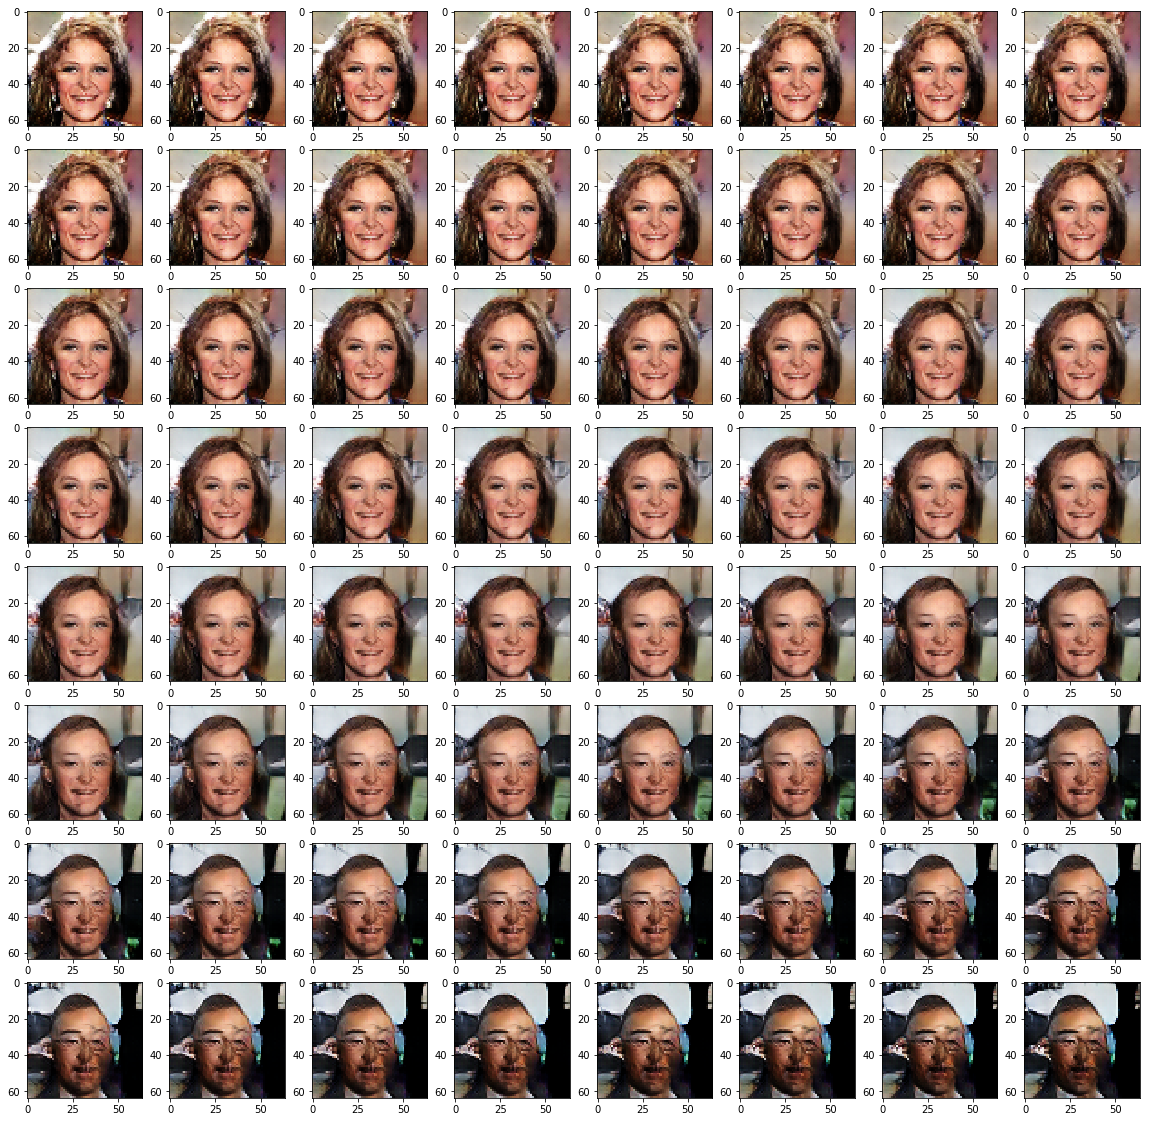

In [15]:
with tf.Session() as sess:
    load(sess, 'checkpoint')
    z1 = np.random.normal(-1,1, Z_DIM)
    z2 = np.random.normal(-1,1, Z_DIM)
    alpha_range = np.linspace(0,1, num=BATCH_SIZE)
    batchz = np.array([alpha * z1 + (1-alpha) * z2 for alpha in alpha_range])
    input_z12 = sess.run(G, feed_dict={z: batchz, is_training: False})
    img12= inverse_transform(input_z12)

fig=plt.figure(figsize=(20, 20))
columns = 8
rows = 8
for i in range(1, columns*rows+1):
    img = img12[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)  
plt.show()

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

# Display some faces

INFO:tensorflow:Restoring parameters from checkpoint\dcgan.model


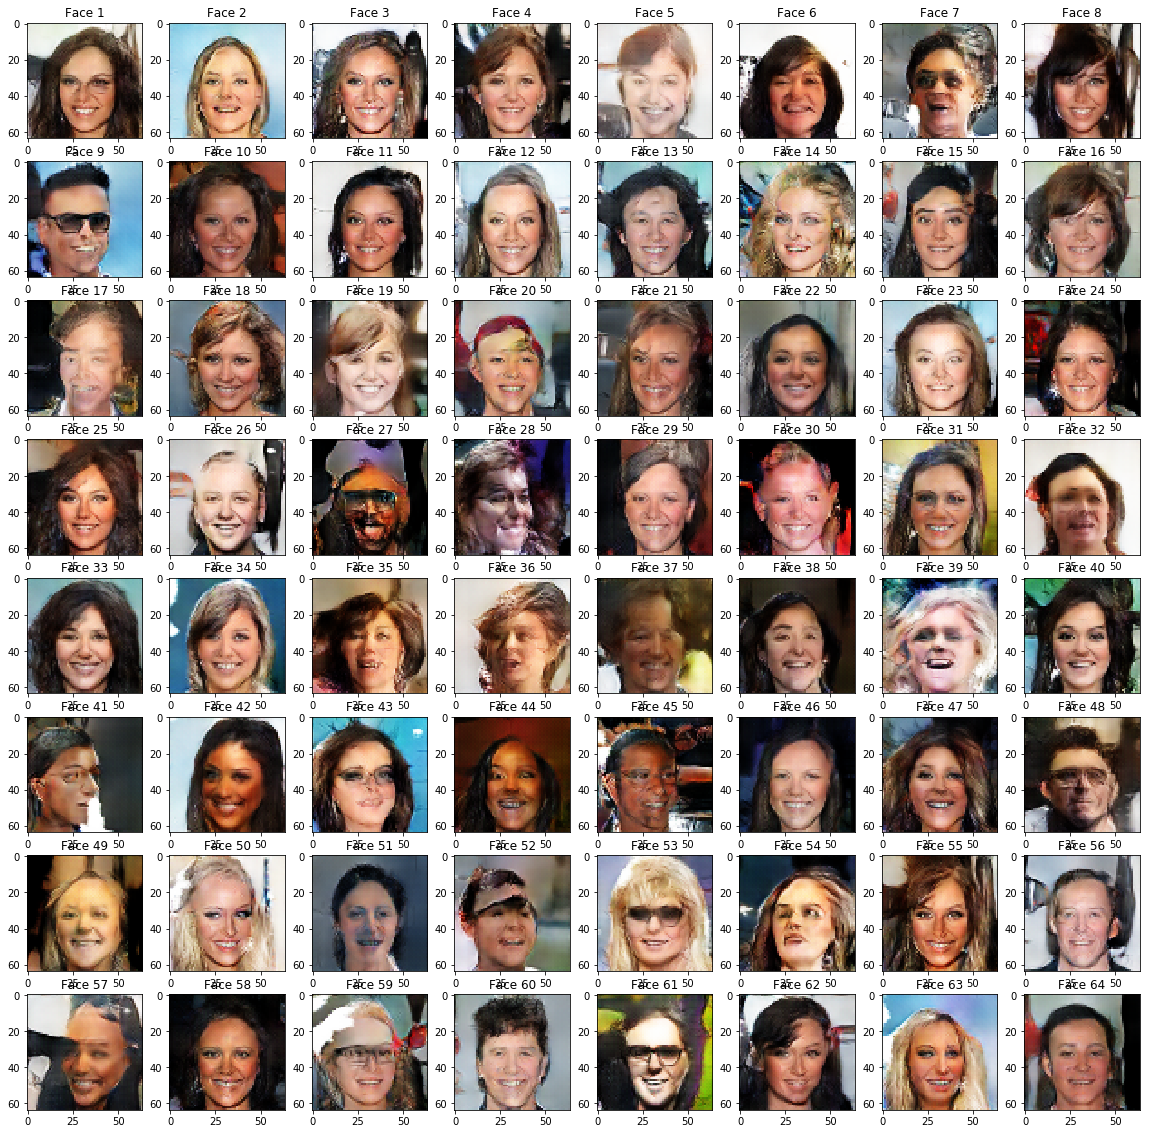

In [13]:
with tf.Session() as sess:
    load(sess, 'checkpoint')
    batchz = np.random.normal(-1,1,size=[BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batchz, is_training: False})
    imgs = inverse_transform(samples)

fig = plt.figure(figsize=(20, 20))
numColumns = 8
numRows = 8
for i in range(1, numColumns*numRows + 1):
    img_i = imgs[i-1]
    fig.add_subplot(numRows, numColumns, i)
    plt.imshow(img_i)
    plt.title('Face ' + str(i))
plt.show()

# Choose manually smiling faces

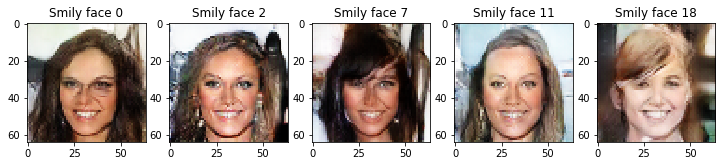

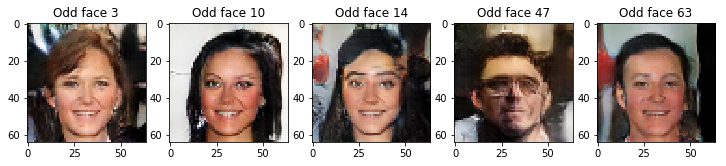

In [14]:
img_smile = [0, 2, 7, 11, 18]
img_odd = [3, 10, 14, 47, 63]

# Display the smiling faces
fig = plt.figure(figsize=(20, 20))
numColumns = 8
numRows = 1
idx = 1
for i in img_smile:
    img_i = imgs[i]
    fig.add_subplot(numRows, numColumns, idx)
    plt.imshow(img_i)
    idx += 1
    plt.title('Smily face ' + str(i))
plt.show()

# Display the odd faces
fig = plt.figure(figsize=(20, 20))
numColumns = 8
numRows = 1
idx = 1
for i in img_odd:
    img_i = imgs[i]
    fig.add_subplot(numRows, numColumns, idx)
    plt.imshow(img_i)
    idx += 1
    plt.title('Odd face ' + str(i))
plt.show()

# Make them smile :)

* Taking the difference between the means of the smiling and the odd face z's
* Subtracting this values from the z's 

INFO:tensorflow:Restoring parameters from checkpoint\dcgan.model


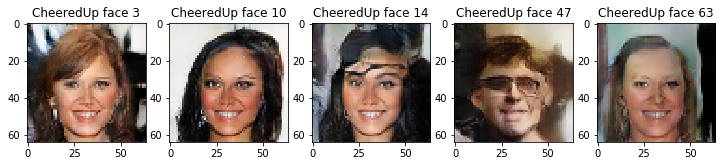

In [15]:
with tf.Session() as sess:
    load(sess, 'checkpoint')
    batchz_smile = np.array([batchz[i] for i in img_smile])
    batchz_odd = np.array([batchz[i] for i in img_odd])
    batchz_cheeredUp = batchz + (batchz_smile.mean(axis=0) - batchz_odd.mean(axis=0))
    samples_cheeredUp = sess.run(G, feed_dict={z: batchz_cheeredUp, is_training: False})
    imgs_cheeredUp = inverse_transform(samples_cheeredUp)

# Display the odd faces now smiling
fig = plt.figure(figsize=(20, 20))
numColumns = 8
numRows = 1
idx = 1
for i in img_odd:
    img_i = imgs_cheeredUp[i]
    fig.add_subplot(numRows, numColumns, idx)
    plt.imshow(img_i)
    idx += 1
    plt.title('CheeredUp face ' + str(i))
plt.show()

If faces looks really cool, add bonus 1 point to your score.